# Volatility and Time Series Decomposition Features Exploration
## Experiments with Tree-based Scikit-learn models | Quantitative Analysis

**Objective**: The primary objective of this notebook is to perform experimentation with the tree-based models for multi-step ahead forecasting with *Quant* features. 



In [1]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # Use __file__ for portability

# Move up one level to the project root
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

# Change working directory
os.chdir(project_root)

# Verify the change
print(os.getcwd()) 

/home/michel/projects/tree-based-forecasting-boilerplate


In [2]:
%load_ext autoreload
%autoreload 2

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import ta  # Technical Analysis library for Bollinger Bands, RSI, etc.
from arch import arch_model

from scripts.run_wfv import *
from src.models.train_model import *
from src.models.evaluate_model import *
from src.models.predict_model import *
from src.visualization.data_viz import *

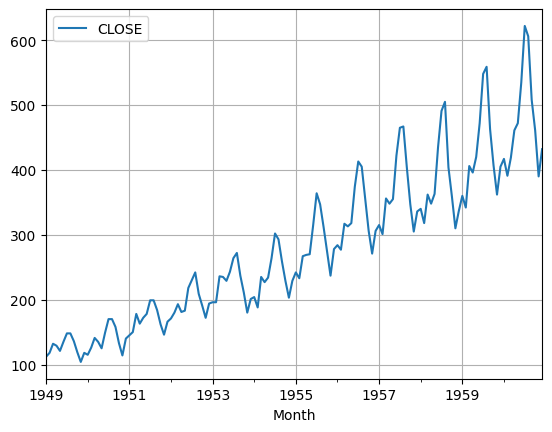

In [3]:
df = pd.read_csv(os.path.join('./data/raw', 'AirPassengers.csv'), parse_dates=["Month"])
df = df.set_index("Month")
df = df.rename(columns={"#Passengers": "CLOSE"})
df.plot()
plt.grid()
plt.show()

## 1.0 Volatility Features
### Exploring Basic Volatility Features: Standard Deviation, Amplitude

In [4]:
# Calculando os Retornos Logarítmicos
df['Log_Returns'] = np.log(df['CLOSE'] / df['CLOSE'].shift(1))

# Volatilidade Histórica (Desvio Padrão dos Retornos)
df['Historical_Volatility'] = df['Log_Returns'].rolling(window=12).std()
df['MAX_12'] = df['CLOSE'].rolling(window=12, closed='left', min_periods=2).max()
df['MIN_12'] = df['CLOSE'].rolling(window=12, closed='left', min_periods=2).min()
df['AMPLITUDE_12'] = df['MAX_12'] - df['MIN_12']
df['DIFF_AMPLITUDE_12'] = df['AMPLITUDE_12'].diff()
# Média Móvel Exponencial (EMA)
df['EMA_12'] = df['CLOSE'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['CLOSE'].ewm(span=24, adjust=False).mean()

# Desvio Padrão Móvel
df['Rolling_Std'] = df['CLOSE'].rolling(window=12).std()
df['SMA_21'] = df['CLOSE'].rolling(window=12).mean()

# Coeficiente de Variação
df['Coefficient_of_Variation'] = df['Rolling_Std'] / df['SMA_21']
df['Absolute_Returns'] = df['Log_Returns'].abs()
df.dropna(inplace=True)


In [5]:
df.head()

,CLOSE,Log_Returns,Historical_Volatility,MAX_12,MIN_12,AMPLITUDE_12,DIFF_AMPLITUDE_12,EMA_12,EMA_26,Rolling_Std,SMA_21,Coefficient_of_Variation,Absolute_Returns
Month,,,,,,,,,,,,,
1950-01-01,115,-0.025752,0.095370,148.0,104.0,44.0,0.0,122.111849,120.520843,13.453342,126.916667,0.106001,0.025752
1950-02-01,126,0.091350,0.097873,148.0,104.0,44.0,0.0,122.710026,120.959176,13.166475,127.583333,0.103199,0.091350
1950-03-01,141,0.112478,0.097909,148.0,104.0,44.0,0.0,125.523868,122.562442,13.686977,128.333333,0.106652,0.112478
1950-04-01,135,-0.043485,0.098627,148.0,104.0,44.0,0.0,126.981735,123.557446,13.822467,128.833333,0.107290,0.043485
1950-05-01,125,-0.076961,0.099502,148.0,104.0,44.0,0.0,126.676852,123.672851,13.663710,129.166667,0.105784,0.076961


In [6]:
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)

In [7]:
df_scaled.head()

,CLOSE,Log_Returns,Historical_Volatility,MAX_12,MIN_12,AMPLITUDE_12,DIFF_AMPLITUDE_12,EMA_12,EMA_26,Rolling_Std,SMA_21,Coefficient_of_Variation,Absolute_Returns
0,0.001969,0.442296,0.254346,0.0,0.0,0.0,0.350515,0.000000,0.000000,0.004015,0.000000,0.174461,0.115408
1,0.023622,0.704688,0.305327,0.0,0.0,0.0,0.350515,0.001596,0.001292,0.000000,0.001909,0.148945,0.409377
2,0.053150,0.752031,0.306056,0.0,0.0,0.0,0.350515,0.009104,0.006015,0.007285,0.004056,0.180383,0.504061
3,0.041339,0.402562,0.320683,0.0,0.0,0.0,0.350515,0.012993,0.008947,0.009181,0.005488,0.186190,0.194875
4,0.021654,0.327553,0.338515,0.0,0.0,0.0,0.350515,0.012180,0.009287,0.006959,0.006442,0.172478,0.344895


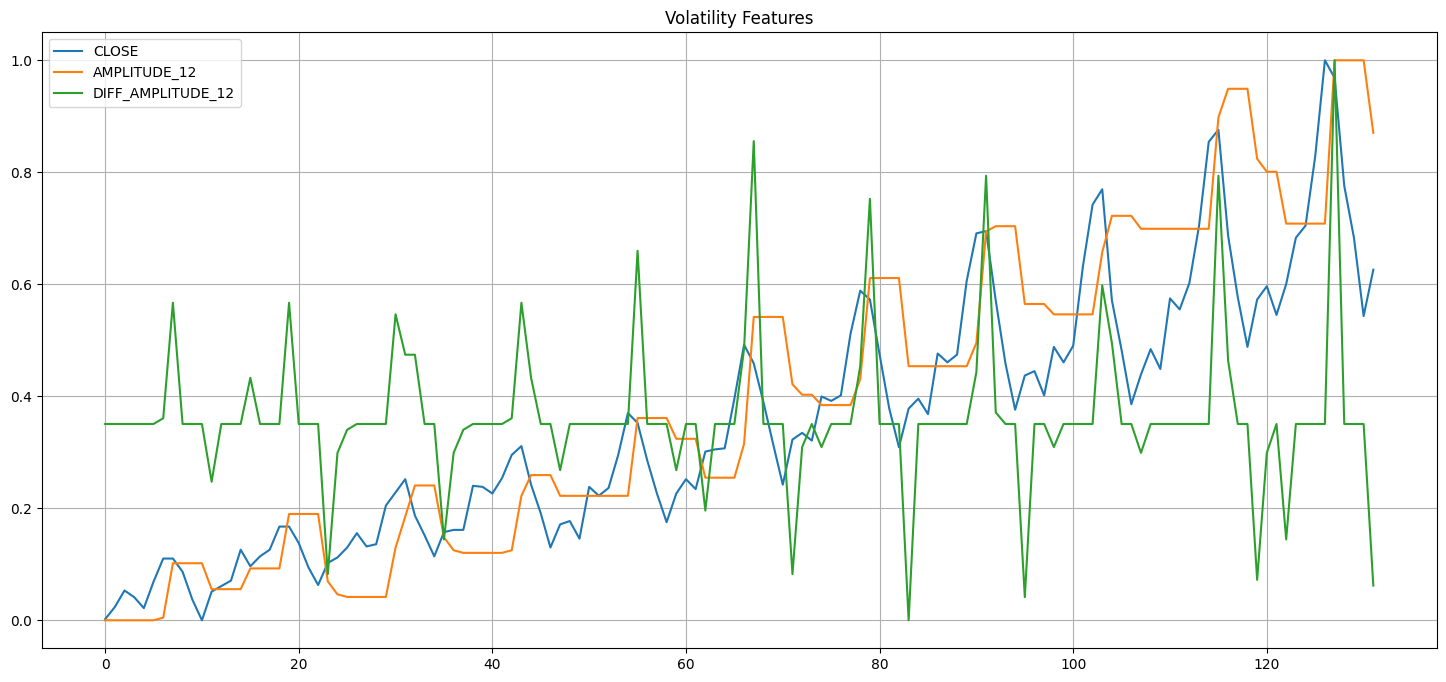

In [8]:
df_scaled[["CLOSE", "AMPLITUDE_12", "DIFF_AMPLITUDE_12"]].plot(figsize=(18, 8)) # "EMA_12", "EMA_26", "SMA_21"
plt.title("Volatility Features")
plt.grid()
plt.show()

In [9]:
df_scaled.corr()

,CLOSE,Log_Returns,Historical_Volatility,MAX_12,MIN_12,AMPLITUDE_12,DIFF_AMPLITUDE_12,EMA_12,EMA_26,Rolling_Std,SMA_21,Coefficient_of_Variation,Absolute_Returns
CLOSE,1.000000,0.099998,0.315724,0.906223,0.907842,0.866940,0.236055,0.936360,0.925451,0.907346,0.917685,0.615841,0.076705
Log_Returns,0.099998,1.000000,-0.010636,-0.097990,0.000934,-0.226897,-0.223824,-0.088029,-0.072310,-0.157804,-0.050583,-0.326159,0.082577
Historical_Volatility,0.315724,-0.010636,1.000000,0.362707,0.312175,0.415751,0.049699,0.343408,0.354230,0.419372,0.338335,0.539848,0.176457
MAX_12,0.906223,-0.097990,0.362707,1.000000,0.987036,0.976470,0.042061,0.994381,0.997648,0.973494,0.995964,0.639203,0.096269
MIN_12,0.907842,0.000934,0.312175,0.987036,1.000000,0.929199,-0.019390,0.981096,0.988994,0.934223,0.994402,0.536679,0.066399
AMPLITUDE_12,0.866940,-0.226897,0.415751,0.976470,0.929199,1.000000,0.122906,0.971511,0.968424,0.986397,0.957279,0.750785,0.132460
DIFF_AMPLITUDE_12,0.236055,-0.223824,0.049699,0.042061,-0.019390,0.122906,1.000000,0.079036,0.046923,0.133098,0.017441,0.320822,-0.273851
EMA_12,0.936360,-0.088029,0.343408,0.994381,0.981096,0.971511,0.079036,1.000000,0.998031,0.978673,0.993644,0.653315,0.112839
EMA_26,0.925451,-0.072310,0.354230,0.997648,0.988994,0.968424,0.046923,0.998031,1.000000,0.972918,0.997852,0.630720,0.105587
Rolling_Std,0.907346,-0.157804,0.419372,0.973494,0.934223,0.986397,0.133098,0.978673,0.972918,1.000000,0.958471,0.779859,0.163556


In [10]:
df.corr()

,CLOSE,Log_Returns,Historical_Volatility,MAX_12,MIN_12,AMPLITUDE_12,DIFF_AMPLITUDE_12,EMA_12,EMA_26,Rolling_Std,SMA_21,Coefficient_of_Variation,Absolute_Returns
CLOSE,1.000000,0.099998,0.315724,0.906223,0.907842,0.866940,0.236055,0.936360,0.925451,0.907346,0.917685,0.615841,0.076705
Log_Returns,0.099998,1.000000,-0.010636,-0.097990,0.000934,-0.226897,-0.223824,-0.088029,-0.072310,-0.157804,-0.050583,-0.326159,0.082577
Historical_Volatility,0.315724,-0.010636,1.000000,0.362707,0.312175,0.415751,0.049699,0.343408,0.354230,0.419372,0.338335,0.539848,0.176457
MAX_12,0.906223,-0.097990,0.362707,1.000000,0.987036,0.976470,0.042061,0.994381,0.997648,0.973494,0.995964,0.639203,0.096269
MIN_12,0.907842,0.000934,0.312175,0.987036,1.000000,0.929199,-0.019390,0.981096,0.988994,0.934223,0.994402,0.536679,0.066399
AMPLITUDE_12,0.866940,-0.226897,0.415751,0.976470,0.929199,1.000000,0.122906,0.971511,0.968424,0.986397,0.957279,0.750785,0.132460
DIFF_AMPLITUDE_12,0.236055,-0.223824,0.049699,0.042061,-0.019390,0.122906,1.000000,0.079036,0.046923,0.133098,0.017441,0.320822,-0.273851
EMA_12,0.936360,-0.088029,0.343408,0.994381,0.981096,0.971511,0.079036,1.000000,0.998031,0.978673,0.993644,0.653315,0.112839
EMA_26,0.925451,-0.072310,0.354230,0.997648,0.988994,0.968424,0.046923,0.998031,1.000000,0.972918,0.997852,0.630720,0.105587
Rolling_Std,0.907346,-0.157804,0.419372,0.973494,0.934223,0.986397,0.133098,0.978673,0.972918,1.000000,0.958471,0.779859,0.163556


## 2.0 Stochastic Oscilator, RSI, Bollinger Bands

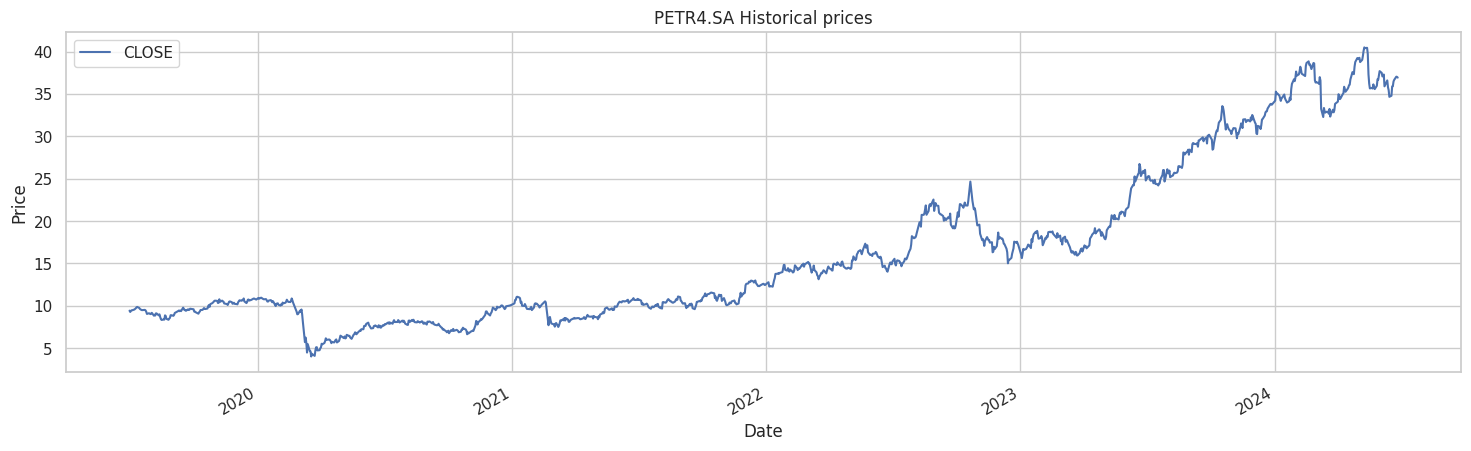

In [43]:
df = pd.read_csv(os.path.join('./data/processed', 'processed_df.csv'), parse_dates=["DATE"])
df.set_index("DATE", inplace=True)

ticker = 'PETR4.SA'
df = df[df["TICKER"] == ticker]
df.head()
df[["CLOSE"]].plot(figsize=(18, 5))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"{ticker} Historical prices")
plt.show()

### 2.1 Oscilador Estocástico

            CLOSE         %K         %D
DATE                                   
2019-08-13  8.992  39.747928  37.612763
2019-08-14  8.688   7.318504  23.892084
2019-08-15  8.448   3.570740  16.879057
2019-08-16  8.336   0.697713   3.862319
2019-08-19  8.378   6.357246   3.541900
            CLOSE         %K         %D
DATE                                   
2024-06-20  36.50  63.486467  52.950409
2024-06-21  36.69  72.625449  61.399843
2024-06-24  37.06  83.204753  73.105557
2024-06-25  37.03  82.346972  79.392392
2024-06-26  36.95  86.039437  83.863721


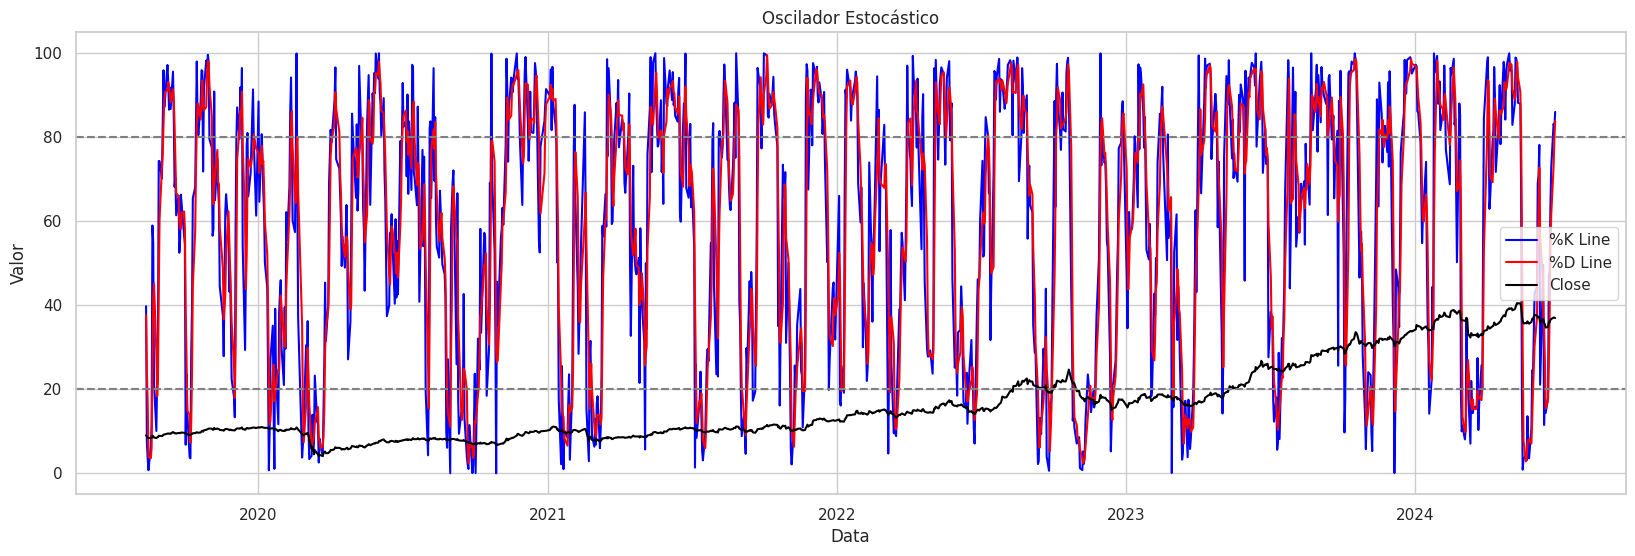

In [47]:
# Definir o período para o Oscilador Estocástico
period = 14

# Calcular a linha %K
df['L14'] = df['LOW'].rolling(window=period).min()
df['H14'] = df['HIGH'].rolling(window=period).max()
df['%K'] = 100 * (df['CLOSE'] - df['L14']) / (df['H14'] - df['L14'])

# Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(df['CLOSE'], window=14).rsi()

# Calcular a linha %D (média móvel simples da linha %K)
df['%D'] = df['%K'].rolling(window=3).mean()

# Remover valores nulos (resultantes das operações de rolagem)
df.dropna(inplace=True)

# Visualizar os primeiros registros
print(df[['CLOSE', '%K', '%D']].head())
print(df[['CLOSE', '%K', '%D']].tail())

# Visualizar o Oscilador Estocástico no gráfico

plt.figure(figsize=(20, 6))
plt.plot(df.index, df['%K'], label='%K Line', color='blue')
plt.plot(df.index, df['%D'], label='%D Line', color='red')
plt.plot(df.index, df['CLOSE'], label='Close', color='black')
plt.axhline(y=80, color='grey', linestyle='--')
plt.axhline(y=20, color='grey', linestyle='--')
plt.legend()
plt.title('Oscilador Estocástico')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()


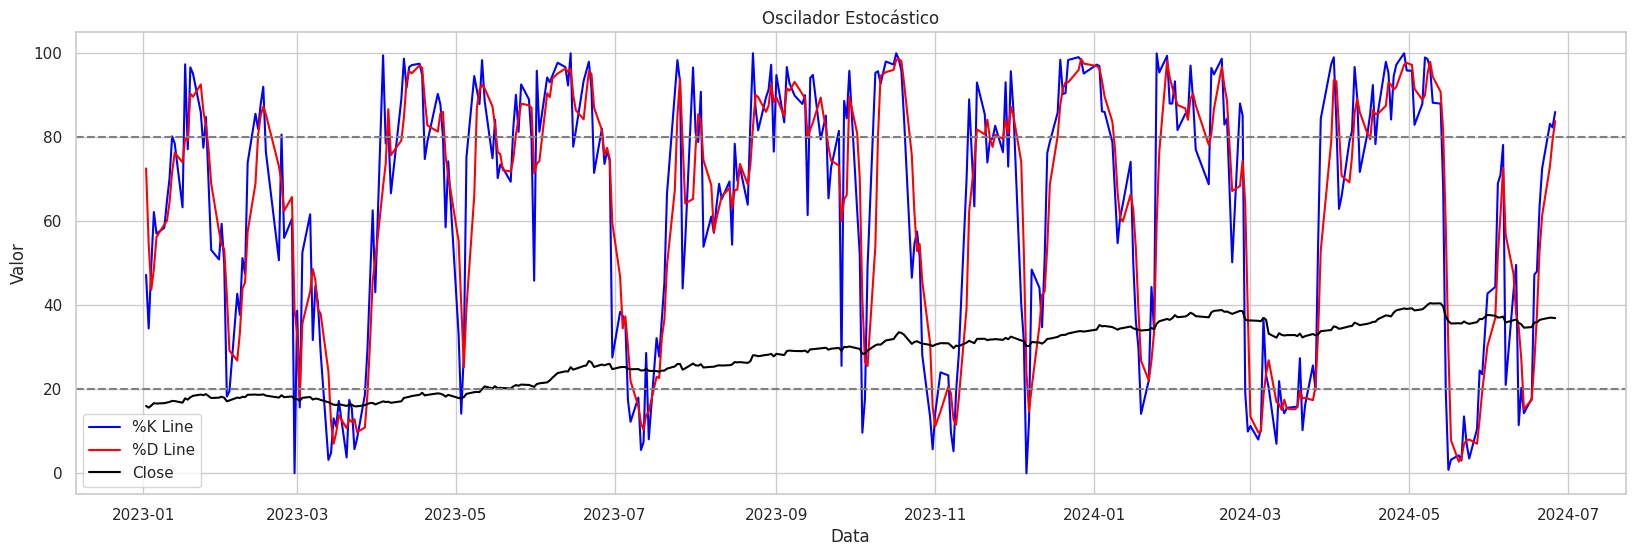

In [46]:
df_2024 = df[df.index >= pd.to_datetime('2023-01-01')].copy()

plt.figure(figsize=(20, 6))
plt.plot(df_2024.index, df_2024['%K'], label='%K Line', color='blue')
plt.plot(df_2024.index, df_2024['%D'], label='%D Line', color='red')
plt.plot(df_2024.index, df_2024['CLOSE'], label='Close', color='black')
plt.axhline(y=80, color='grey', linestyle='--')
plt.axhline(y=20, color='grey', linestyle='--')
plt.legend()
plt.title('Oscilador Estocástico')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()


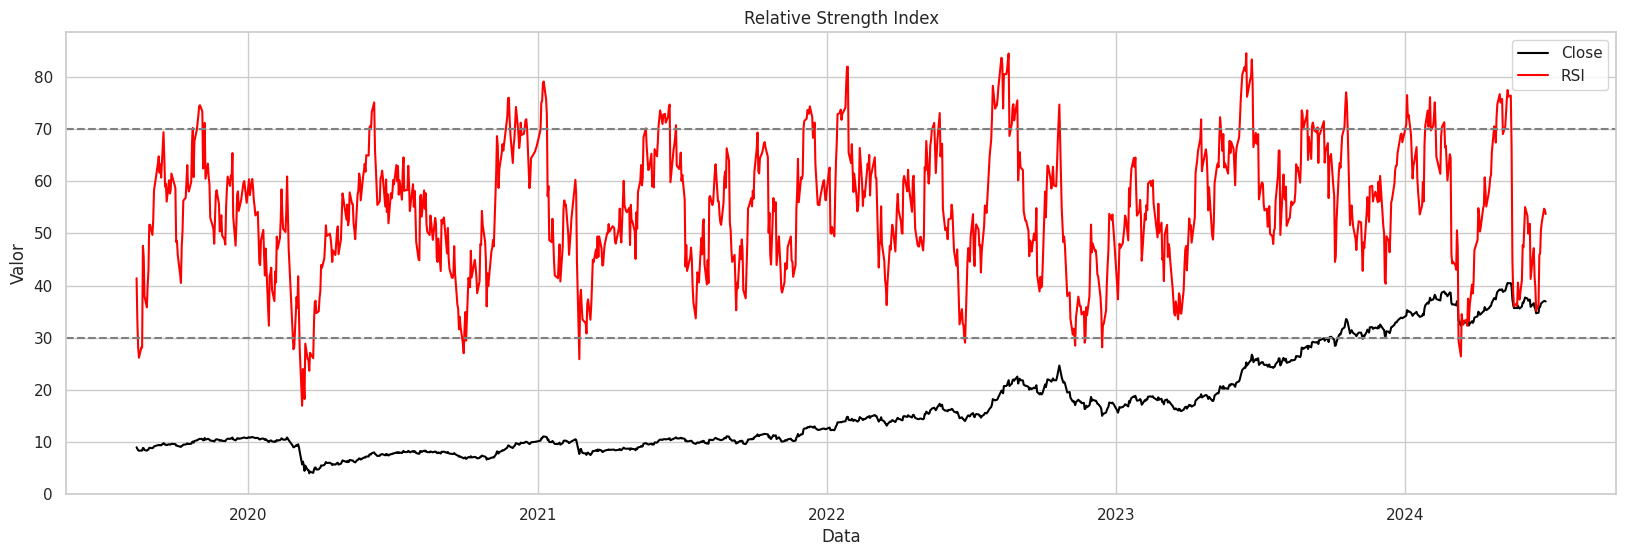

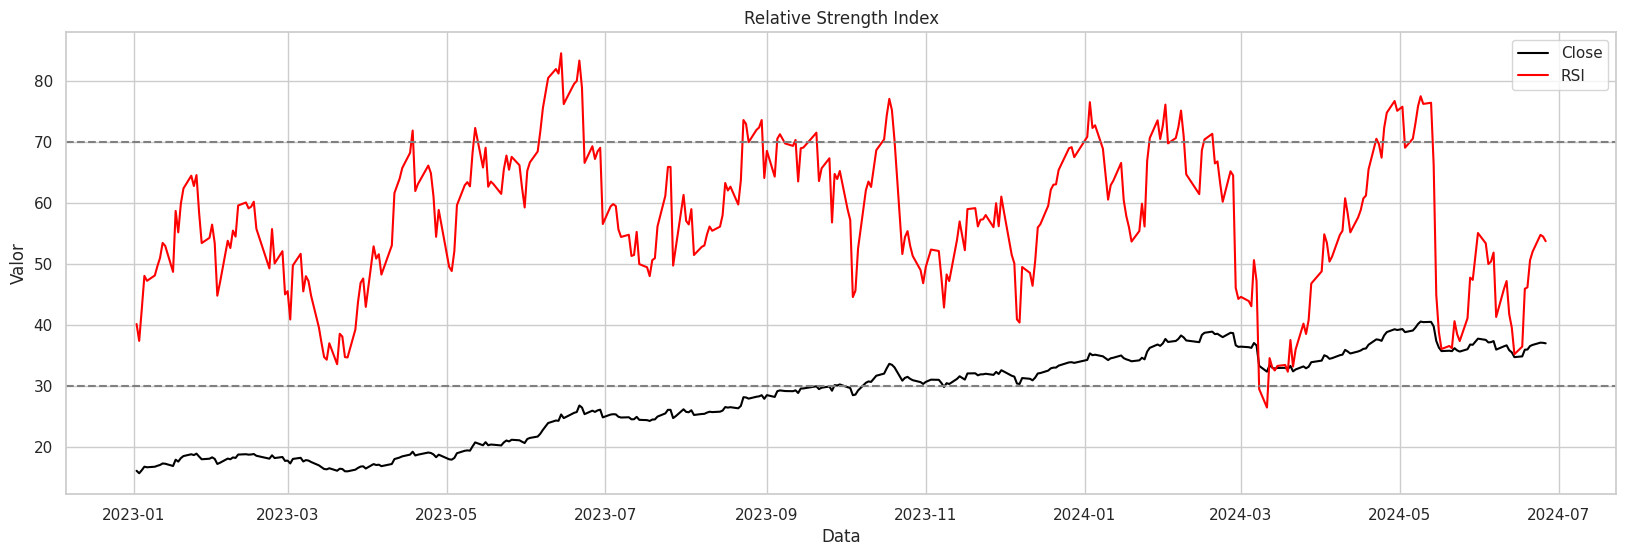

In [53]:
df_2024 = df[df.index >= pd.to_datetime('2023-01-01')].copy()
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['CLOSE'], label='Close', color='black')
plt.plot(df.index, df['RSI'], label='RSI', color='red')
plt.axhline(y=70, color='grey', linestyle='--')
plt.axhline(y=30, color='grey', linestyle='--')
plt.legend()
plt.title('Relative Strength Index')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(df_2024.index, df_2024['CLOSE'], label='Close', color='black')
plt.plot(df_2024.index, df_2024['RSI'], label='RSI', color='red')
plt.axhline(y=70, color='grey', linestyle='--')
plt.axhline(y=30, color='grey', linestyle='--')
plt.legend()
plt.title('Relative Strength Index')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()